In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, inspect, MetaData, Table
from sqlalchemy import select, func, and_, or_, desc, case, cast, Numeric, text
from local_settings import postgresql as settings
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [3]:
# Define a function for creating the sqlalchemy engine
def get_engine(user, passwd, host, port, db):
    url = f"postgresql+psycopg2://{user}:{passwd}@{host}:{port}/{db}"
    engine = create_engine(url, pool_size= 50, echo= False)

    return engine

# Create the engine and respective connection
engine = get_engine(
    user= settings['pguser'],
    passwd= settings['pgpasswd'],
    host= settings['pghost'],
    port= settings['pgport'],
    db= settings['pgdb']
)

connection = engine.connect()

Once the engine is connected to the remote database, we can use the `inspect` function from SQLAlchemy to examine the contents of the database, i.e. its tables.

In [46]:
path = os.getcwd() + '/food_carbon_footprint_2018_long.csv'
foodprint_2018 = pd.read_csv(path, sep= ';')
foodprint_2018.to_sql(name= 'foodprint', con= connection, if_exists= 'replace', index= False)

250

In [5]:
inspector = inspect(engine)

print(inspector.get_table_names())

['foodprint']


In [3]:
metadata= MetaData()
foodprint = Table('foodprint', metadata, autoload_replace= True, autoload_with= engine)

In [4]:
# Define a function for retrieving the result proxy

def fetch_query_results(input_type, input):
    """
    Fetch query results as a pandas DataFrame.

    Parameters:
    ----------
    input_type : str
        'stmt' for a SQLAlchemy statement, or 'query' for a raw SQL string.
    input_value : object
        SQLAlchemy statement or raw SQL string depending on input_type.

    Returns:
    -------
    pd.DataFrame
        Query results as a DataFrame.
    """
    
    if input_type == 'stmt':
        results = connection.execute(input).fetchall()
        return pd.DataFrame(results)
    elif input_type == 'query':
        return pd.read_sql_query(input, connection)
    else:
        print("Invalid input_type. Please choose 'stmt' for SQLAlchemy statements or 'query' for raw SQL strings.")

In [5]:
stmt = select(foodprint)

print(stmt, '\n')

fetch_query_results(input_type= 'stmt', input= stmt).head(5)

SELECT foodprint.country, foodprint.product, foodprint.metric, foodprint.value 
FROM foodprint 



,country,product,metric,value
0,Argentina,Pork,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Supplied for Consumption (kg/person/year),22.29


In [14]:
# Dimensions of the foodprint table
stmt = select(func.count()).select_from(foodprint)

print(f"({connection.execute(stmt).scalar()}, {len(foodprint.columns)})")

(3250, 4)


In [6]:
# Data type of each column
for column in foodprint.columns:
    print(f"{column.key}: {column.type}")

country: TEXT
product: TEXT
metric: TEXT
value: DOUBLE PRECISION


In [8]:
# Missing data in each column
print("Missing values: \n")
for column in foodprint.columns:
    stmt = select(func.count()).where(column.is_(None))
    result = connection.execute(stmt).scalar()
    print(f"{column.key}: {result}")

Missing values: 

country: 0
product: 0
metric: 0
value: 0


In [6]:
# Number of countries under analysis for each product and metric

query = """
    SELECT product,
           metric,
           COUNT(country) AS number_of_countries
        FROM foodprint
        GROUP BY product, metric
        ORDER BY product, metric
"""

fetch_query_results('query', query)


,product,metric,number_of_countries
0,Animal products,Total Kg CO2/year/person,130
1,Beef,Kg CO2/person/year,130
2,Beef,Supplied for Consumption (kg/person/year),130
3,Difference Animal Non-Animals,Products/person/year in kg,130
4,Eggs,Kg CO2/person/year,130
5,Eggs,Supplied for Consumption (kg/person/year),130
6,Fish,Kg CO2/person/year,130
7,Fish,Supplied for Consumption (kg/person/year),130
8,Lamb & Goat,Kg CO2/person/year,130
9,Lamb & Goat,Supplied for Consumption (kg/person/year),130


In the `product` and `metric` fields, there are a few values that do not correspond directly to individual items in these categories, as they aggregate information at a global level. Specifically, the values `Animal products`, `Non-animal products` and `Difference Animal Non-Animals` appear in the `product` field. The first two are associated with the metric `Total Kg CO₂/year/person` in the `metric` field, and the latter to a `Products/person/year in kg` metric.

To address this particular feature, the dataset can be transformed by filtering out these values and then creating a new categorical field in which `Animal` and `Non-animal` product categories are distinguished. Regarding the `Difference Animal Non-Animals` item, there is no need to keep it in the dataset, as it can be assessed based on these two categories in the new field.

In [6]:
animal = ['Beef', 'Eggs', 'Fish', 'Lamb & Goat', 'Milk - inc. Cheese', 'Pork', 'Poultry']
non_animal = ['Wheat & Wheat Products', 'Rice', 'Soybeans', 'Nuts inc. Peanut Butter']
filter_out = ['Animal products', 'Non-animal products', 'Difference Animal Non-Animals']

stmt = select(foodprint.columns.country,
              foodprint.columns.product,
              case(
                    (foodprint.columns.product.in_(animal), 'Animal'),
                    (foodprint.columns.product.in_(non_animal), 'Non-animal'),
                    else_= None).label('product_category'),
              foodprint.columns.metric,
              foodprint.columns.value
)

stmt = stmt.where(foodprint.columns.product.not_in(filter_out))

print(stmt, '\n')

fetch_query_results('stmt', stmt).head()

SELECT foodprint.country, foodprint.product, CASE WHEN (foodprint.product IN (__[POSTCOMPILE_product_1])) THEN :param_1 WHEN (foodprint.product IN (__[POSTCOMPILE_product_2])) THEN :param_2 END AS product_category, foodprint.metric, foodprint.value 
FROM foodprint 
WHERE (foodprint.product NOT IN (__[POSTCOMPILE_product_3])) 



,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Animal,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Animal,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Animal,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Animal,Supplied for Consumption (kg/person/year),22.29


In [12]:
# Update the foodprint table in the remote database
(
    fetch_query_results('stmt', stmt)
    .to_sql("foodprint1", engine, if_exists= 'replace', index= False, chunksize= 1000, method= 'multi')
)

2860

In [5]:
# Inspect the existence of foodprint_bkp in the remote database
inspector = inspect(engine)
print(inspector.get_table_names())

['foodprint1', 'foodprint']


After making sure of the existence of the original and the altered table in the `foodprint_2018` remote database, instantiate the `foodprint1` table in the SQLAlchemy context, and take a look at the first 10 rows:

In [6]:
metadata = MetaData()

foodprint1 = Table('foodprint1', metadata, autoload_replace= True, autoload_with= engine)

query = """
    SELECT *
        FROM foodprint1
        LIMIT 5
"""

fetch_query_results('query', query)

,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Animal,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Animal,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Animal,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Animal,Supplied for Consumption (kg/person/year),22.29


In [9]:
# Data type pf each column in foodprint1
for col in foodprint1.columns:
    print(f"{col.key}: {col.type}")

country: TEXT
product: TEXT
product_category: TEXT
metric: TEXT
value: DOUBLE PRECISION


#### Analysis by product

In [ ]:
# Animal vs Non-animal emissions

query = """
    SELECT  product_category
           ,metric
           ,SUM(value) AS sum
           ,SUM(value) / (SUM(SUM(value)) OVER()) AS Percentage
           ,AVG(value) AS mean
        FROM foodprint1
        WHERE metric ILIKE 'Kg CO2/person/year'
        GROUP BY product_category, metric
"""

df = fetch_query_results('query', query)
df

,product_category,metric,sum,percentage,mean
0,Animal,Kg CO2/person/year,98706.08,0.927958,108.468220
1,Non-animal,Kg CO2/person/year,7663.03,0.072042,14.736596


Diet is a significant driver of greenhouse gas emissions, with food production systems contributing substantially to global CO₂ outputs. The environmental impact of different food sources varies widely, particularly between animal-based and non-animal-based products. Understanding the relative contributions of these sources to per capita emissions is essential for informing sustainable dietary strategies and climate policy.  
The following chart presents a comparative breakdown of animal and non-animal contributions, showing each product’s share of annual CO₂ emissions as well as the average annual CO₂ emissions per person.


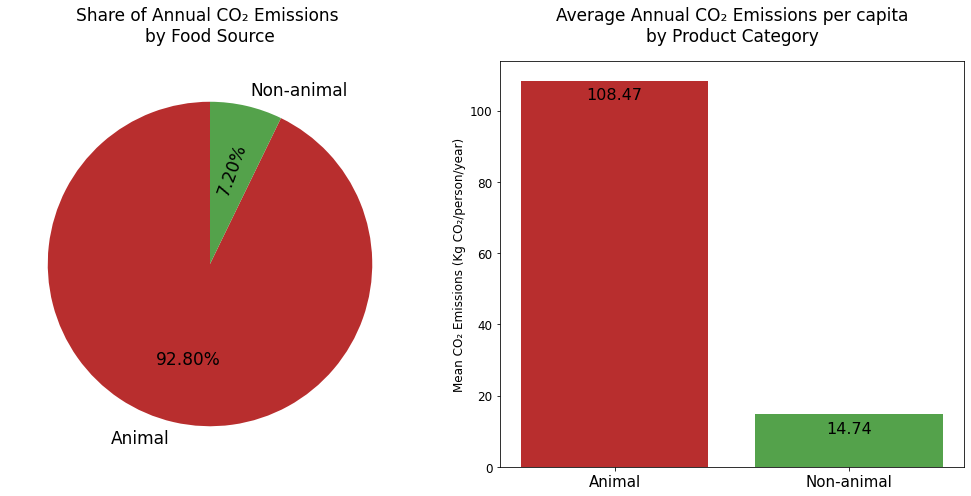

In [95]:

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 7))
wedges, texts, autotexts= ax1.pie(
    df['sum'],
    labels= df['product_category'],
    autopct='%1.2f%%',
    colors= ['#B82E2E', '#54A24B'],
    startangle=90,
    textprops={'fontsize': 17}
)
autotexts[1].set_rotation(70)
ax1.set_title('Share of Annual CO₂ Emissions \nby Food Source',
              fontsize=17,
              pad=20  # Adds space under the title
)

ax2.bar(df['product_category'], 
        df['mean'], 
        color= ['#B82E2E', '#54A24B'])

ax2.set_ylabel('Mean CO₂ Emissions (Kg CO₂/person/year)', fontsize=12)
ax2.set_title('Average Annual CO₂ Emissions per capita\nby Product Category', fontsize=17, pad= 20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=12)

bars = ax2.bar(df['product_category'], df['mean'], color=['#B82E2E', '#54A24B'])
ax2.bar_label(bars, fmt='%.2f', padding=-22, fontsize=16)

plt.tight_layout()
plt.show()


The proportions of animal and non-animal-based food products' contributions to atmospheric emissions reveal a clear disparity, with animal products accounting for the majority of emissions and underscoring their heavier environmental footprint. This imbalance stems from the resource-intensive nature of animal agriculture, which typically involves greater land use, feed production, and methane output compared to plant-based alternatives. In this sense, the mean annual emissions per capita from animal products are roughly seven times higher than those from non-animal products. By quantifying these differences, the chart emphasizes how dietary composition, specifically the dominance of animal-based foods, plays a critical role in shaping the carbon footprint of global food systems.

In [9]:
# Mean per capita consumption per product category
stmt = select(foodprint1.columns.product_category,
              foodprint1.columns.metric,
              func.avg(foodprint1.columns.value).label('average_annual_consumption_per_capita_in_kg'))

stmt = stmt.where(foodprint1.columns.metric.ilike('Supplied %'))

stmt = stmt.group_by(foodprint1.columns.product_category,
                     foodprint1.columns.metric)

print(stmt)

df = fetch_query_results('stmt', stmt)
df

SELECT foodprint1.product_category, foodprint1.metric, avg(foodprint1.value) AS average_annual_consumption_per_capita_in_kg 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.product_category, foodprint1.metric


,product_category,metric,average_annual_consumption_per_capita_in_kg
0,Animal,Supplied for Consumption (kg/person/year),29.041714
1,Non-animal,Supplied for Consumption (kg/person/year),26.480615


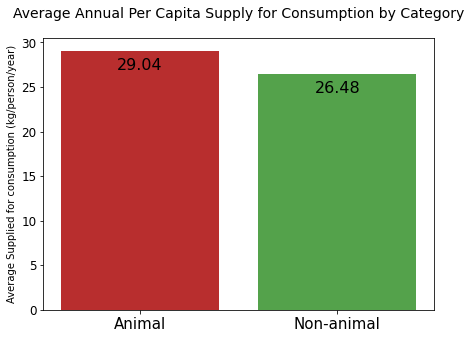

In [98]:
fig, ax = plt.subplots(figsize = (7, 5))

ax.bar(df['product_category'], 
        df['average_annual_consumption_per_capita_in_kg'], 
        color= ['#B82E2E', '#54A24B'])

ax.set_title('Average Annual Per Capita Supply for Consumption by Category', fontsize= 14, pad = 20)
ax.set_ylabel('Average Supplied for consumption (kg/person/year)')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=12)

bars = ax.bar(df['product_category'], 
              df['average_annual_consumption_per_capita_in_kg'], 
              color=['#B82E2E', '#54A24B'])
ax.bar_label(bars, fmt= '%.2f', padding= -22, fontsize= 16)

plt.show()

In [9]:
# Rank products by CO2 emissions

emissions_cte = (
    select(foodprint1.columns.product,
           foodprint1.columns.product_category,
           func.sum(foodprint1.columns.value).label('total_emissions'))
    .group_by(foodprint1.columns.product,
              foodprint1.columns.product_category)
    .where(foodprint1.columns.metric.ilike('Kg %'))
    .order_by(desc('total_emissions'))
    .cte('emissions')
)

stmt = select(emissions_cte,
              func.rank().over(order_by= desc('total_emissions')).label('emissions_rank'))

print(stmt)

fetch_query_results('stmt', stmt)

WITH emissions AS 
(SELECT foodprint1.product AS product, foodprint1.product_category AS product_category, sum(foodprint1.value) AS total_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.product, foodprint1.product_category ORDER BY total_emissions DESC)
 SELECT emissions.product, emissions.product_category, emissions.total_emissions, rank() OVER (ORDER BY emissions.total_emissions DESC) AS emissions_rank 
FROM emissions


,product,product_category,total_emissions,emissions_rank
0,Beef,Animal,48633.26,1
1,Milk - inc. Cheese,Animal,23290.00,2
2,Lamb & Goat,Animal,11837.38,3
3,Pork,Animal,7419.11,4
4,Rice,Non-animal,4886.91,5
5,Fish,Animal,3588.22,6
6,Poultry,Animal,2963.16,7
7,Wheat & Wheat Products,Non-animal,1773.78,8
8,Eggs,Animal,974.95,9
9,Nuts inc. Peanut Butter,Non-animal,951.99,10


In [10]:
# Supplied for consumption ranking
supplied_cte = (
    select(foodprint1.columns.product,
           foodprint1.columns.product_category,
           func.sum(foodprint1.columns.value).label('total_supplied'))
    .where(foodprint1.columns.metric.ilike('Supplied %'))
    .group_by(foodprint1.columns.product, foodprint1.columns.product_category)
    .cte('supplied')
)
 
stmt = select(supplied_cte,
              func.rank().over(order_by= desc('total_supplied')).label('supplied_rank'))

print(stmt)

fetch_query_results('stmt', stmt)


WITH supplied AS 
(SELECT foodprint1.product AS product, foodprint1.product_category AS product_category, sum(foodprint1.value) AS total_supplied 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.product, foodprint1.product_category)
 SELECT supplied.product, supplied.product_category, supplied.total_supplied, rank() OVER (ORDER BY supplied.total_supplied DESC) AS supplied_rank 
FROM supplied


,product,product_category,total_supplied,supplied_rank
0,Milk - inc. Cheese,Animal,16350.71,1
1,Wheat & Wheat Products,Non-animal,9301.44,2
2,Rice,Non-animal,3818.77,3
3,Poultry,Animal,2758.50,4
4,Fish,Animal,2247.32,5
5,Pork,Animal,2096.08,6
6,Beef,Animal,1576.04,7
7,Eggs,Animal,1061.29,8
8,Nuts inc. Peanut Butter,Non-animal,537.84,9
9,Lamb & Goat,Animal,338.02,10


In [11]:
# Join CTEs and find out emissions intensity [(kg co2/person/year) / (Kg supplied/person/year)]
    # ... = kg CO2 / kg supplied

stmt = select(emissions_cte.columns.product,
              emissions_cte.columns.product_category,
              emissions_cte.columns.total_emissions,
              func.rank().over(order_by= desc(emissions_cte.columns.total_emissions)).label('emissions_rank'),
              supplied_cte.columns.total_supplied,
              func.rank().over(order_by= desc(supplied_cte.columns.total_supplied)).label('supplied_rank'),
              (emissions_cte.columns.total_emissions / supplied_cte.columns.total_supplied).label('emissions_intensity'))

stmt = stmt.select_from(emissions_cte.join(supplied_cte,
                                           emissions_cte.columns.product == supplied_cte.columns.product))

stmt = stmt.order_by(desc('emissions_intensity'))

print(stmt)

df = fetch_query_results('stmt', stmt)
df

WITH emissions AS 
(SELECT foodprint1.product AS product, foodprint1.product_category AS product_category, sum(foodprint1.value) AS total_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.product, foodprint1.product_category ORDER BY total_emissions DESC), 
supplied AS 
(SELECT foodprint1.product AS product, foodprint1.product_category AS product_category, sum(foodprint1.value) AS total_supplied 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_2) GROUP BY foodprint1.product, foodprint1.product_category)
 SELECT emissions.product, emissions.product_category, emissions.total_emissions, rank() OVER (ORDER BY emissions.total_emissions DESC) AS emissions_rank, supplied.total_supplied, rank() OVER (ORDER BY supplied.total_supplied DESC) AS supplied_rank, emissions.total_emissions / CAST(supplied.total_supplied AS DOUBLE PRECISION) AS emissions_intensity 
FROM emissions JOIN supplied ON emissions.product = supplied.product 

,product,product_category,total_emissions,emissions_rank,total_supplied,supplied_rank,emissions_intensity
0,Lamb & Goat,Animal,11837.38,3,338.02,10,35.019762
1,Beef,Animal,48633.26,1,1576.04,7,30.857884
2,Pork,Animal,7419.11,4,2096.08,6,3.539517
3,Nuts inc. Peanut Butter,Non-animal,951.99,10,537.84,9,1.770025
4,Fish,Animal,3588.22,6,2247.32,5,1.596666
5,Milk - inc. Cheese,Animal,23290.00,2,16350.71,1,1.424403
6,Rice,Non-animal,4886.91,5,3818.77,3,1.279708
7,Poultry,Animal,2963.16,7,2758.50,4,1.074192
8,Eggs,Animal,974.95,9,1061.29,8,0.918646
9,Soybeans,Non-animal,50.35,11,111.87,11,0.450076


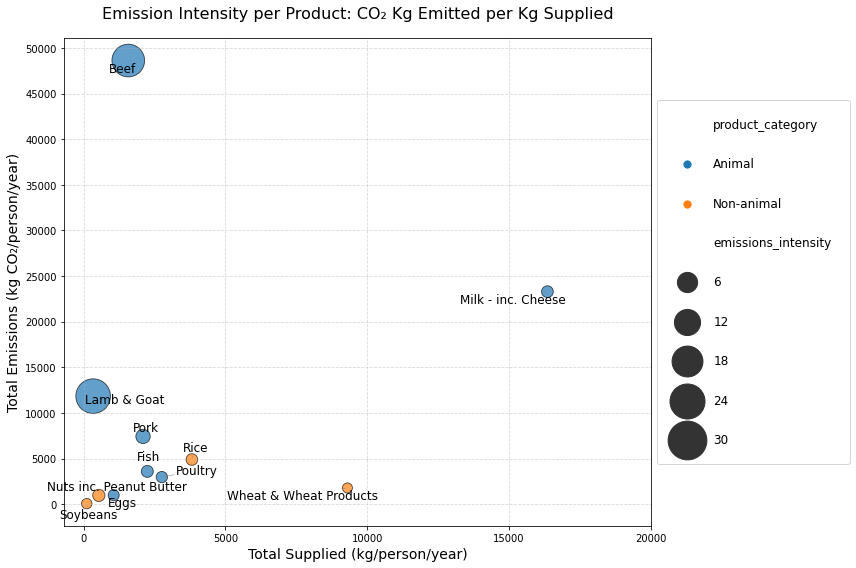

In [101]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=df,
                x='total_supplied',
                y='total_emissions',
                size='emissions_intensity',
                hue='product_category',
                sizes=(100, 1200),  # Increased size range
                alpha=0.7,
                edgecolor='black',
                legend='brief'
                )

texts = []
for i, row in df.iterrows():
    texts.append(
        plt.text(row['total_supplied'], row['total_emissions'],
                 row['product'], fontsize=12, ha='center', va='center')
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Increase xticks and yticks
x_min = int(df['total_supplied'].min() // 5000 * 5000)
x_max = int(df['total_supplied'].max() // 5000 * 5000 + 5000)
y_min = int(df['total_emissions'].min() // 5000 * 5000)
y_max = int(df['total_emissions'].max() // 5000 * 5000 + 5000)
plt.xticks(np.arange(x_min, x_max + 1, 5000))
plt.yticks(np.arange(y_min, y_max + 1, 5000))


plt.xlabel('Total Supplied (kg/person/year)', fontsize=14)
plt.ylabel('Total Emissions (kg CO₂/person/year)', fontsize=14)
plt.title('Emission Intensity per Product: CO₂ Kg Emitted per Kg Supplied', fontsize=16, pad=20)

plt.legend(title='',
           title_fontsize=13,      # Increase title font size
           fontsize=12,            # Increase label font size
           markerscale=1.2,        # Enlarge legend marker size
           borderpad=1.5,          # Space inside legend border
           labelspacing=2.2,       # Space between labels
           handletextpad=1.2,      # Space between marker and text
           loc='center left',      # Position of legend
           bbox_to_anchor=(1, 0.5),
           frameon=True            # Show legend frame (box)
        )

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


This means for each kilogram of a product consumed, how many kilograms of CO₂ are emitted in its production or supply chain. It's a direct measure of carbon intensity per unit of food — highly useful for sustainability and diet impact analysis.

#### Analysis by country

In [48]:
# Top 10 most polluting countries, from both animal and non-animal food

query = text("""
    SELECT country
          ,metric
          ,SUM(value) AS total_emissions
        FROM foodprint1
        WHERE metric ILIKE 'Kg %'
        GROUP BY country, metric
        ORDER BY total_emissions DESC
        LIMIT 10
""")

fetch_query_results('query', query)

,country,metric,total_emissions
0,Argentina,Kg CO2/person/year,2172.40
1,Australia,Kg CO2/person/year,1938.66
2,Albania,Kg CO2/person/year,1777.85
3,New Zealand,Kg CO2/person/year,1750.95
4,Iceland,Kg CO2/person/year,1731.36
5,USA,Kg CO2/person/year,1718.86
6,Uruguay,Kg CO2/person/year,1634.91
7,Brazil,Kg CO2/person/year,1616.73
8,Luxembourg,Kg CO2/person/year,1598.41
9,Kazakhstan,Kg CO2/person/year,1575.08


In [55]:
# Top 10 countries with highest average emissions, from both animal and non-animal food
query = text("""
    SELECT country
          ,metric
          ,AVG(value)::NUMERIC(12,2) AS average_emissions
        FROM foodprint
        WHERE metric ILIKE 'kG %'
        GROUP BY country, metric
        ORDER BY average_emissions DESC
        LIMIT 10
""")

fetch_query_results('query', query)

,country,metric,average_emissions
0,Argentina,Kg CO2/person/year,197.49
1,Australia,Kg CO2/person/year,176.24
2,Albania,Kg CO2/person/year,161.62
3,New Zealand,Kg CO2/person/year,159.18
4,Iceland,Kg CO2/person/year,157.40
5,USA,Kg CO2/person/year,156.26
6,Uruguay,Kg CO2/person/year,148.63
7,Brazil,Kg CO2/person/year,146.98
8,Luxembourg,Kg CO2/person/year,145.31
9,Kazakhstan,Kg CO2/person/year,143.19


In [8]:
# Average emissions by product_category per country in the top 10 emission generators

cat_avg_cte = (select(foodprint1.columns.country,
               foodprint1.columns.product_category,
               foodprint1.columns.metric,
               func.sum(foodprint1.columns.value).label('total_emissions'),
               func.avg(foodprint1.columns.value).label('average_emissions'))
            .where(foodprint1.columns.metric.ilike('Kg %'))
            .group_by(foodprint1.columns.country,
                      foodprint1.columns.product_category,  
                      foodprint1.columns.metric)
            .order_by(desc('total_emissions'))
            .cte('cat_avg_cte')
        )

top10_cte = (select(foodprint1.columns.country,
                    foodprint1.columns.metric,
                    func.sum(foodprint1.columns.value).label('total_emissions'))
                .where(foodprint1.columns.metric.ilike('Kg %'))
                .group_by(foodprint1.columns.country,
                          foodprint1.columns.metric)
                .order_by(desc('total_emissions'))
                .limit(10)
                .cte('top10_cte')
        )

stmt = (select(cat_avg_cte.columns.country,
               cat_avg_cte.columns.product_category,
               cat_avg_cte.columns.metric,
               cat_avg_cte.columns.average_emissions)
        .select_from(cat_avg_cte.join(top10_cte, 
                                      cat_avg_cte.columns.country == top10_cte.columns.country))
        .order_by(cat_avg_cte.columns.country,
                  cat_avg_cte.columns.product_category)
      )



df = fetch_query_results('stmt', stmt)
df

,country,product_category,metric,average_emissions
0,Albania,Animal,Kg CO2/person/year,247.675714
1,Albania,Non-animal,Kg CO2/person/year,11.030000
2,Argentina,Animal,Kg CO2/person/year,305.807143
3,Argentina,Non-animal,Kg CO2/person/year,7.937500
4,Australia,Animal,Kg CO2/person/year,270.794286
5,Australia,Non-animal,Kg CO2/person/year,10.775000
6,Brazil,Animal,Kg CO2/person/year,223.240000
7,Brazil,Non-animal,Kg CO2/person/year,13.512500
8,Iceland,Animal,Kg CO2/person/year,243.650000
9,Iceland,Non-animal,Kg CO2/person/year,6.452500


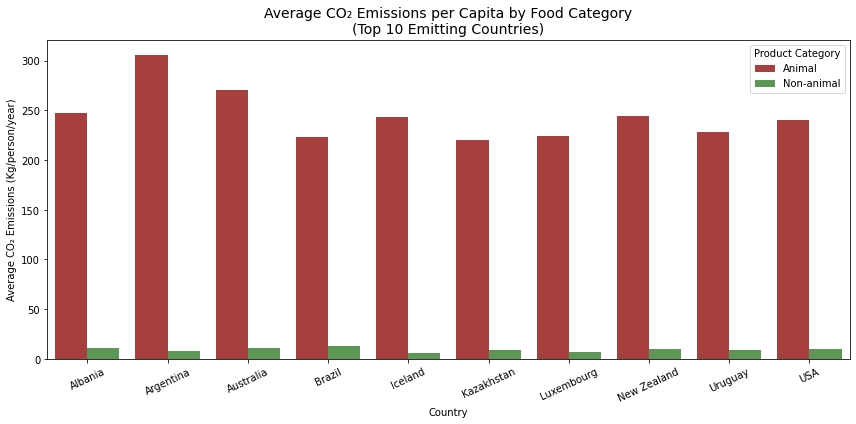

In [61]:
plt.figure(figsize=(12,6))

sns.barplot(
    data= df,
    x= 'country',
    y= 'average_emissions',
    hue= 'product_category',
    palette={'Animal': '#B82E2E', 'Non-animal': '#54A24B'}
)
plt.title('Average CO₂ Emissions per Capita by Food Category\n(Top 10 Emitting Countries)', fontsize=14)
plt.ylabel('Average CO₂ Emissions (Kg/person/year)')
plt.xlabel('Country')
plt.xticks(rotation=25)
plt.legend(title='Product Category')
plt.tight_layout()
plt.show()

Break down the emissions by product per country

In [9]:
stmt1 = (
    select(foodprint1.c.country,
           foodprint1.c.product,
           foodprint1.c.metric,
           foodprint1.c.value)
    .where(and_(
        foodprint1.c.metric.ilike('Kg %'),
        foodprint1.c.country.in_(
            select(top10_cte.c.country)
            ),
        foodprint1.c.product_category.ilike('Animal')
        )
    )
)

stmt0 = (
    select(foodprint1.c.country,
           foodprint1.c.product,
           foodprint1.c.metric,
           foodprint1.c.value)
    .where(and_(
        foodprint1.c.metric.ilike('Kg %'),
        foodprint1.c.country.in_(
            select(top10_cte.c.country)
            ),
        foodprint1.c.product_category.ilike('Non-animal')
        )
    )
)

df_animal = fetch_query_results('stmt', stmt1)
df_non_animal = fetch_query_results('stmt', stmt0)

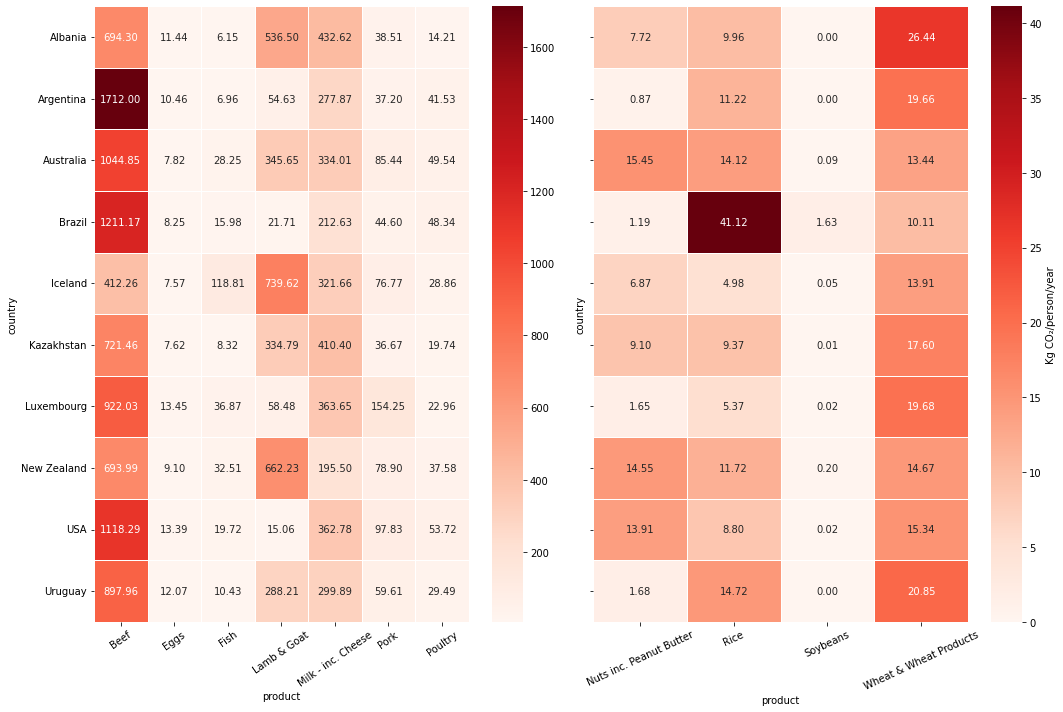

In [14]:
pivot_animal = df_animal.pivot(index= 'country', columns= 'product', values= 'value')
pivot_non_animal = df_non_animal.pivot(index= 'country', columns= 'product', values= 'value')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (15, 10), sharey= True)

sns.heatmap(pivot_animal, ax= ax1, annot= True, cmap= 'Reds', fmt= '.2f', 
            linewidths= 0.5
        )
ax1.tick_params(axis= 'x', labelrotation= 35)

sns.heatmap(pivot_non_animal, ax= ax2, annot= True, cmap= 'Reds', fmt= '.2f', 
            linewidths= 0.5, cbar_kws={'label': 'Kg CO₂/person/year'}
        )
ax2.tick_params(axis= 'x', labelrotation= 25)

plt.tight_layout()
plt.show()

What are the most supplied-for-consumption products in the top 10 most polluting countries?

In [49]:
ranks_cte = (
    select(foodprint1.columns.country,
           foodprint1.columns.product,
           foodprint1.columns.product_category,
           foodprint1.columns.metric,
           foodprint1.columns.value,
           func.rank().over(partition_by= [foodprint1.columns.country, foodprint1.columns.metric],
                            order_by= desc(foodprint1.columns.value)).label('rank'))
    .cte('ranks_cte')
)

top10_cte = (
    select(foodprint1.columns.country,
           func.sum(foodprint1.columns.value).label('total_emissions'))
    .where(foodprint1.columns.metric.ilike('Kg %'))
    .group_by(foodprint1.columns.country)
    .order_by(desc('total_emissions'))
    .limit(10)
    .cte('top10_cte')
)

stmt = (select(ranks_cte)
        .select_from(ranks_cte.join(top10_cte,
                                    ranks_cte.columns.country == top10_cte.columns.country))
        .where(and_(ranks_cte.columns.rank == 1,
                    ranks_cte.columns.metric.ilike('Supplied %')))
        .order_by(ranks_cte.columns.metric, desc(ranks_cte.columns.value))
)

print(stmt)

fetch_query_results('stmt', stmt)

WITH ranks_cte AS 
(SELECT foodprint1.country AS country, foodprint1.product AS product, foodprint1.product_category AS product_category, foodprint1.metric AS metric, foodprint1.value AS value, rank() OVER (PARTITION BY foodprint1.country, foodprint1.metric ORDER BY foodprint1.value DESC) AS rank 
FROM foodprint1), 
top10_cte AS 
(SELECT foodprint1.country AS country, sum(foodprint1.value) AS total_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.country ORDER BY total_emissions DESC
 LIMIT :param_1)
 SELECT ranks_cte.country, ranks_cte.product, ranks_cte.product_category, ranks_cte.metric, ranks_cte.value, ranks_cte.rank 
FROM ranks_cte JOIN top10_cte ON ranks_cte.country = top10_cte.country 
WHERE ranks_cte.rank = :rank_1 AND lower(ranks_cte.metric) LIKE lower(:metric_2) ORDER BY ranks_cte.metric, ranks_cte.value DESC


,country,product,product_category,metric,value,rank
0,Albania,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),303.72,1
1,Kazakhstan,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),288.12,1
2,Luxembourg,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),255.30,1
3,USA,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),254.69,1
4,Australia,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),234.49,1
5,Iceland,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),225.82,1
6,Uruguay,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),210.54,1
7,Argentina,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),195.08,1
8,Brazil,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),149.28,1
9,New Zealand,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),137.25,1


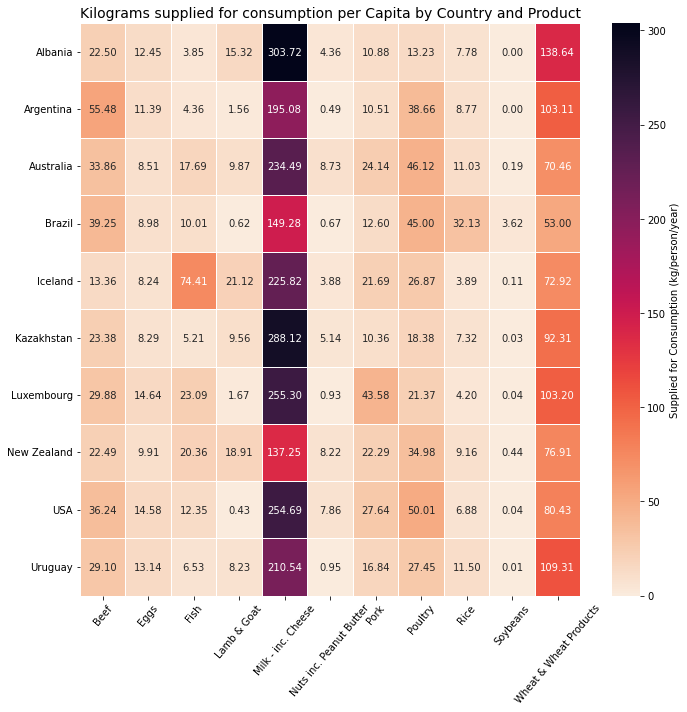

In [16]:
stmt = (
    select(foodprint1.c.country,
           foodprint1.c.product,
           foodprint1.c.metric,
           foodprint1.c.value)
    .where(and_(
        foodprint1.c.country.in_(select(top10_cte.c.country)),
        foodprint1.c.metric.ilike('Supplied %')
    ))
)

df = fetch_query_results('stmt', stmt)

pivot_df = df.pivot(index= 'country', columns= 'product', values= 'value')

plt.figure(figsize = (10,10))

sns.heatmap(
    pivot_df,
    cmap= 'rocket_r',
    annot= True,
    fmt = '.2f',
    linewidths= 0.5,
    cbar_kws= {'label': 'Supplied for Consumption (kg/person/year)'}
)
plt.title("Kilograms supplied for consumption per Capita by Country and Product", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis= 'x', labelrotation= 50, )

plt.tight_layout()
plt.show()


Bottom 10 polluting countries

In [50]:
bottom10_subq = (
        select(foodprint1.columns.country,
              foodprint1.columns.metric,
              func.sum(foodprint1.columns.value).label('total_emissions'),
              func.round(cast(func.avg(foodprint1.columns.value), Numeric), 2).label('average_emissions')
              )
        .where(foodprint1.columns.metric.ilike('Kg %'))
        .group_by(foodprint1.columns.country, foodprint1.columns.metric)
        .order_by('total_emissions')
        .limit(10)
    ).subquery()

stmt = select(bottom10_subq)

print(stmt)

fetch_query_results('stmt', stmt)

SELECT anon_1.country, anon_1.metric, anon_1.total_emissions, anon_1.average_emissions 
FROM (SELECT foodprint1.country AS country, foodprint1.metric AS metric, sum(foodprint1.value) AS total_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.country, foodprint1.metric ORDER BY total_emissions
 LIMIT :param_1) AS anon_1


,country,metric,total_emissions,average_emissions
0,Mozambique,Kg CO2/person/year,141.40,12.85
1,Rwanda,Kg CO2/person/year,181.63,16.51
2,Togo,Kg CO2/person/year,188.09,17.10
3,Liberia,Kg CO2/person/year,203.38,18.49
4,Malawi,Kg CO2/person/year,207.94,18.90
5,Ghana,Kg CO2/person/year,217.87,19.81
6,Zambia,Kg CO2/person/year,225.30,20.48
7,Ethiopia,Kg CO2/person/year,241.92,21.99
8,Congo,Kg CO2/person/year,262.55,23.87
9,Nigeria,Kg CO2/person/year,267.79,24.34


In [39]:
stmt = (
    select(foodprint1.c.country,
           foodprint1.c.product_category,
           foodprint1.c.metric,
           func.round(cast(func.avg(foodprint1.c.value), Numeric),2).label('average_emissions'))
    .group_by(foodprint1.c.country, foodprint1.c.product_category,foodprint1.c.metric)
    .where(and_(
        foodprint1.c.metric.ilike('Kg%'),
        foodprint1.c.country.in_(
            select(bottom10_subq.c.country)
        )))
    .order_by(foodprint1.c.country, foodprint1.c.product_category, desc('average_emissions'))
)

print(stmt)

df = fetch_query_results('stmt', stmt)
df

SELECT foodprint1.country, foodprint1.product_category, foodprint1.metric, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) AND foodprint1.country IN (SELECT anon_1.country 
FROM (SELECT foodprint1.country AS country, foodprint1.metric AS metric, sum(foodprint1.value) AS total_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_2) AS average_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_2) GROUP BY foodprint1.country, foodprint1.metric ORDER BY total_emissions
 LIMIT :param_1) AS anon_1) GROUP BY foodprint1.country, foodprint1.product_category, foodprint1.metric ORDER BY foodprint1.country, foodprint1.product_category, average_emissions DESC


,country,product_category,metric,average_emissions
0,Congo,Animal,Kg CO2/person/year,32.62
1,Congo,Non-animal,Kg CO2/person/year,8.56
2,Ethiopia,Animal,Kg CO2/person/year,32.96
3,Ethiopia,Non-animal,Kg CO2/person/year,2.80
4,Ghana,Animal,Kg CO2/person/year,23.47
5,Ghana,Non-animal,Kg CO2/person/year,13.40
6,Liberia,Animal,Kg CO2/person/year,11.06
7,Liberia,Non-animal,Kg CO2/person/year,31.49
8,Malawi,Animal,Kg CO2/person/year,27.12
9,Malawi,Non-animal,Kg CO2/person/year,4.53


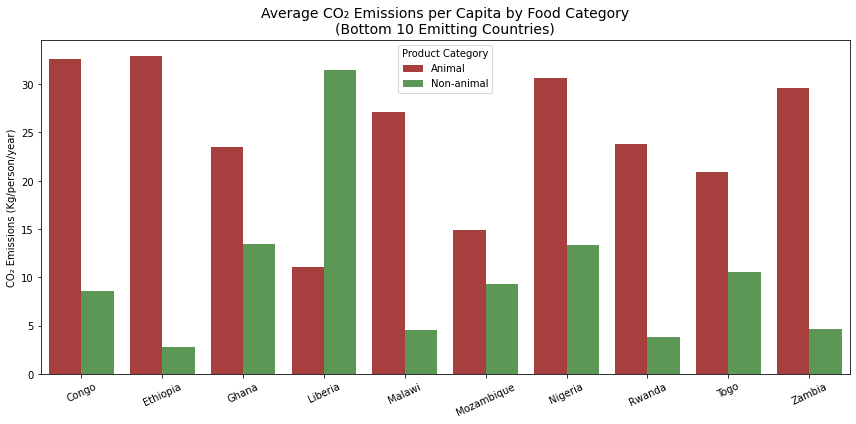

In [40]:
plt.figure(figsize=(12,6))

sns.barplot(
    data= df,
    x= 'country',
    y= 'average_emissions',
    hue= 'product_category',
    palette={'Animal': '#B82E2E', 'Non-animal': '#54A24B'}
)
plt.title('Average CO₂ Emissions per Capita by Food Category\n(Bottom 10 Emitting Countries)', fontsize=14)
plt.ylabel('CO₂ Emissions (Kg/person/year)')
plt.xlabel('')
plt.xticks(rotation=25)
plt.legend(title='Product Category')
plt.tight_layout()
plt.show()

What are the most polluting products from these bottom 10 countries?

In [49]:
bottom10_rank = (
    select(foodprint1,
           func.rank().over(partition_by= [foodprint1.columns.country, foodprint1.columns.metric],
                            order_by= desc(foodprint1.columns.value)).label('rank'))
    .where(foodprint1.columns.country.in_(
        select(bottom10_subq.c.country)
    ))
    .cte('bottom10_rank')
)


stmt = (
    select(bottom10_rank)
    .where(and_(
        bottom10_rank.c.rank == 1,
        bottom10_rank.c.metric.ilike('Kg %')
    ))
    .order_by(bottom10_rank.c.metric, desc(bottom10_rank.c.value))
)

print(stmt)

fetch_query_results('stmt', stmt)

WITH bottom10_rank AS 
(SELECT foodprint1.country AS country, foodprint1.product AS product, foodprint1.product_category AS product_category, foodprint1.metric AS metric, foodprint1.value AS value, rank() OVER (PARTITION BY foodprint1.country, foodprint1.metric ORDER BY foodprint1.value DESC) AS rank 
FROM foodprint1 
WHERE foodprint1.country IN (SELECT anon_1.country 
FROM (SELECT foodprint1.country AS country, foodprint1.metric AS metric, sum(foodprint1.value) AS total_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.country, foodprint1.metric ORDER BY total_emissions
 LIMIT :param_1) AS anon_1))
 SELECT bottom10_rank.country, bottom10_rank.product, bottom10_rank.product_category, bottom10_rank.metric, bottom10_rank.value, bottom10_rank.rank 
FROM bottom10_rank 
WHERE bottom10_rank.rank = :rank_1 AND lower(bottom10_rank.metric) LIKE lower(:metric_2) ORDER 

,country,product,product_category,metric,value,rank
0,Zambia,Beef,Animal,Kg CO2/person/year,146.88,1
1,Congo,Beef,Animal,Kg CO2/person/year,134.23,1
2,Liberia,Rice,Non-animal,Kg CO2/person/year,121.25,1
3,Ethiopia,Beef,Animal,Kg CO2/person/year,111.40,1
4,Nigeria,Lamb & Goat,Animal,Kg CO2/person/year,95.25,1
5,Rwanda,Beef,Animal,Kg CO2/person/year,78.07,1
6,Malawi,Beef,Animal,Kg CO2/person/year,72.52,1
7,Ghana,Lamb & Goat,Animal,Kg CO2/person/year,60.93,1
8,Togo,Lamb & Goat,Animal,Kg CO2/person/year,55.33,1
9,Mozambique,Beef,Animal,Kg CO2/person/year,32.09,1


In [ ]:
# CO2 emissions from bottom 10 polluting countries
stmt = (
    select(foodprint1.c.country,
           foodprint1.c.product,
           foodprint1.c.metric,
           foodprint1.c.value)
    .where(and_(
        foodprint1.c.metric.ilike('Kg %'),
        foodprint1.c.country.in_(
            select(bottom10_subq.c.country)
            ))
        )
    )

df = fetch_query_results('stmt', stmt)
# df_non_animal = fetch_query_results('stmt', stmt0)

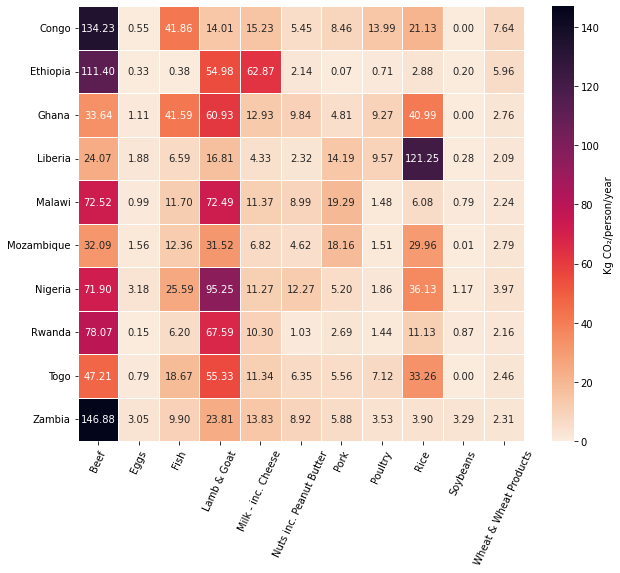

In [ ]:
pivot_df = df.pivot(index= 'country', columns= 'product', values= 'value')

plt.figure(figsize = (10, 8))

sns.heatmap(
    pivot_df,
    cmap= 'rocket_r',
    annot= True,
    fmt = '.2f',
    linewidth= 0.5,
    cbar_kws={'label': 'Kg CO₂/person/year'}
)

plt.ylabel('')
plt.xlabel('')
plt.tick_params('x', labelrotation= 65)

plt.show()

What are the most supplied-for-consumption products in the bottom 10 polluting countries?

In [45]:
stmt = (
    select(bottom10_rank)
    .where(and_(
        bottom10_rank.c.rank == 1,
        bottom10_rank.c.metric.ilike('Supplied %')
    ))
    .order_by(bottom10_rank.c.metric, desc(bottom10_rank.c.value))
)

print(stmt)

fetch_query_results('stmt', stmt)

WITH bottom10_rank AS 
(SELECT foodprint1.country AS country, foodprint1.product AS product, foodprint1.product_category AS product_category, foodprint1.metric AS metric, foodprint1.value AS value, rank() OVER (PARTITION BY foodprint1.country, foodprint1.metric ORDER BY foodprint1.value DESC) AS rank 
FROM foodprint1 
WHERE foodprint1.country IN (SELECT anon_1.country 
FROM (SELECT foodprint1.country AS country, foodprint1.metric AS metric, sum(foodprint1.value) AS total_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.country, foodprint1.metric ORDER BY total_emissions
 LIMIT :param_1) AS anon_1))
 SELECT bottom10_rank.country, bottom10_rank.product, bottom10_rank.product_category, bottom10_rank.metric, bottom10_rank.value, bottom10_rank.rank 
FROM bottom10_rank 
WHERE bottom10_rank.rank = :rank_1 AND lower(bottom10_rank.metric) LIKE lower(:metric_2) ORDER 

,country,product,product_category,metric,value,rank
0,Liberia,Rice,Non-animal,Supplied for Consumption (kg/person/year),94.75,1
1,Ethiopia,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),44.14,1
2,Congo,Wheat & Wheat Products,Non-animal,Supplied for Consumption (kg/person/year),40.07,1
3,Ghana,Rice,Non-animal,Supplied for Consumption (kg/person/year),32.03,1
4,Nigeria,Rice,Non-animal,Supplied for Consumption (kg/person/year),28.23,1
5,Togo,Rice,Non-animal,Supplied for Consumption (kg/person/year),25.99,1
6,Mozambique,Rice,Non-animal,Supplied for Consumption (kg/person/year),23.41,1
7,Zambia,Wheat & Wheat Products,Non-animal,Supplied for Consumption (kg/person/year),12.10,1
8,Malawi,Wheat & Wheat Products,Non-animal,Supplied for Consumption (kg/person/year),11.77,1
9,Rwanda,Wheat & Wheat Products,Non-animal,Supplied for Consumption (kg/person/year),11.34,1


In [60]:
stmt = (
    select(foodprint1.c.country,
           foodprint1.c.product,
           foodprint1.c.metric,
           foodprint1.c.value)
    .where(and_(
        foodprint1.c.metric.ilike('Supplied %'),
        foodprint1.c.country.in_(select(bottom10_subq.c.country))
        )
    )
)

print(stmt)

df = fetch_query_results('stmt', stmt)
df.head(5)


SELECT foodprint1.country, foodprint1.product, foodprint1.metric, foodprint1.value 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) AND foodprint1.country IN (SELECT anon_1.country 
FROM (SELECT foodprint1.country AS country, foodprint1.metric AS metric, sum(foodprint1.value) AS total_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_2) GROUP BY foodprint1.country, foodprint1.metric ORDER BY total_emissions
 LIMIT :param_1) AS anon_1)


,country,product,metric,value
0,Ethiopia,Pork,Supplied for Consumption (kg/person/year),0.02
1,Congo,Pork,Supplied for Consumption (kg/person/year),2.39
2,Zambia,Pork,Supplied for Consumption (kg/person/year),1.66
3,Malawi,Pork,Supplied for Consumption (kg/person/year),5.45
4,Nigeria,Pork,Supplied for Consumption (kg/person/year),1.47


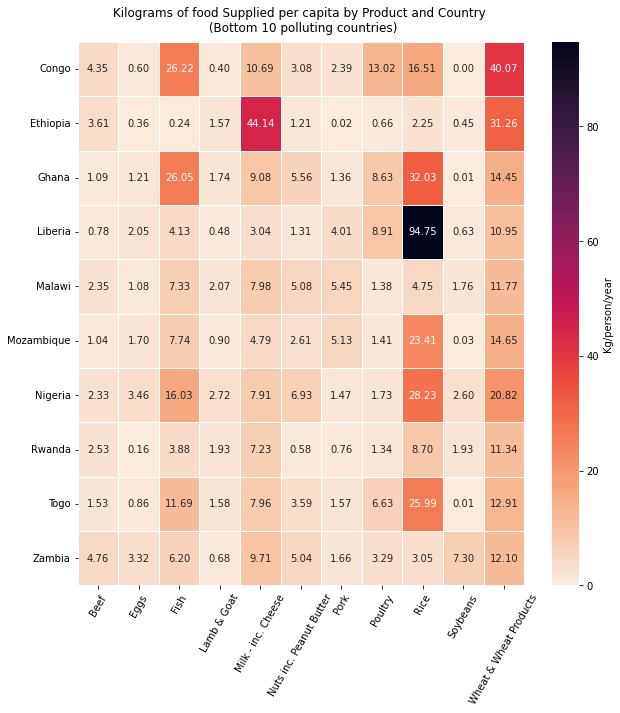

In [ ]:
pivot_df = df.pivot(index= 'country', columns= 'product', values= 'value')


fig, ax = plt.subplots(figsize= (10,10))

sns.heatmap(
    pivot_df,
    ax= ax,
    cmap= 'rocket_r',
    fmt= '.2f',
    annot= True,
    linewidth= 0.5,
    cbar_kws={'label': 'Kg/person/year'}
)
ax.set_title('Kilograms of food Supplied per capita by Product and Country \n (Bottom 10 polluting countries)',
             pad= 10)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis= 'x', labelrotation= 60)
ax.tick_params(axis= 'y', labelrotation= 0)

plt.show()


It is worth noting that Liberia shows a relatively high per capita rice production for the year, with rice also being by far the most supplied product overall when considering both `Animal` and `Non-animal` categories. So far, it is the only country displaying this pattern of higher production and emissions from Non-animal products. Let's now explore whether any other country exhibits a similar trend.

In [84]:
# Countries with emissions from Non-animal greater than Animal

emissions_animal_cte = (
    select(foodprint1.c.country,
           foodprint1.c.product_category,
           foodprint1.c.metric,
           func.sum(foodprint1.c.value).label('total_animal_emissions'),
           func.round(cast(func.avg(foodprint1.c.value), Numeric),2).label('average_animal_emissions')
        )
    .where(and_(
        foodprint1.c.metric.ilike('Kg %'),
        foodprint1.c.product_category.ilike('Animal')
    ))
    .group_by(foodprint1.c.country,foodprint1.c.product_category,foodprint1.c.metric)
    .order_by(desc('total_animal_emissions'))
    .cte('emissions_animal_cte')
)

emissions_non_animal_cte = (
    select(foodprint1.c.country,
           foodprint1.c.product_category,
           foodprint1.c.metric,
           func.sum(foodprint1.c.value).label('total_non_animal_emissions'),
           func.round(cast(func.avg(foodprint1.c.value), Numeric),2).label('average_non_animal_emissions')
        )
    .where(and_(
        foodprint1.c.metric.ilike('Kg %'),
        foodprint1.c.product_category.ilike('Non-Animal')
    ))
    .group_by(foodprint1.c.country,foodprint1.c.product_category,foodprint1.c.metric)
    .order_by(desc('total_non_animal_emissions'))
    .cte('emissions_non_animal_cte')
)

non_animal_countries = (
    select(emissions_animal_cte.c.country,
           emissions_animal_cte.c.metric,
           emissions_animal_cte.c.total_animal_emissions,
           emissions_animal_cte.c.average_animal_emissions,
           emissions_non_animal_cte.c.total_non_animal_emissions,
           emissions_non_animal_cte.c.average_non_animal_emissions,
           (emissions_non_animal_cte.c.total_non_animal_emissions - 
            emissions_animal_cte.c.total_animal_emissions).label('emissions_difference')
        )
    .select_from(emissions_animal_cte.join(emissions_non_animal_cte,
                                           emissions_animal_cte.c.country == emissions_non_animal_cte.c.country))
    .where(emissions_non_animal_cte.c.total_non_animal_emissions > emissions_animal_cte.c.total_animal_emissions)
    .order_by(desc('emissions_difference'))
).subquery()

stmt = select(non_animal_countries)

print(stmt)

fetch_query_results('stmt', stmt)

WITH emissions_animal_cte AS 
(SELECT foodprint1.country AS country, foodprint1.product_category AS product_category, foodprint1.metric AS metric, sum(foodprint1.value) AS total_animal_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_animal_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1) AND lower(foodprint1.product_category) LIKE lower(:product_category_1) GROUP BY foodprint1.country, foodprint1.product_category, foodprint1.metric ORDER BY total_animal_emissions DESC), 
emissions_non_animal_cte AS 
(SELECT foodprint1.country AS country, foodprint1.product_category AS product_category, foodprint1.metric AS metric, sum(foodprint1.value) AS total_non_animal_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_2) AS average_non_animal_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_2) AND lower(foodprint1.product_category) LIKE lower(:product_category_2) GROUP BY foodprint1.country, food

,country,metric,total_animal_emissions,average_animal_emissions,total_non_animal_emissions,average_non_animal_emissions,emissions_difference
0,Bangladesh,Kg CO2/person/year,149.55,21.36,224.63,56.16,75.08
1,Liberia,Kg CO2/person/year,77.44,11.06,125.94,31.49,48.50
2,Indonesia,Kg CO2/person/year,181.18,25.88,186.33,46.58,5.15
3,Sri Lanka,Kg CO2/person/year,145.06,20.72,149.40,37.35,4.34


In [43]:
# What are the most consumed products from these countries

non_animal_countries_ranked = (
    select(
        foodprint1,
        func.rank().over(partition_by= [foodprint1.c.country, foodprint1.c.metric],
                         order_by= desc(foodprint1.c.value)
                        ).label('rank')
    )
    .where(and_(
        foodprint1.c.metric.ilike('Supplied %'),
        foodprint1.c.country.in_(select(non_animal_countries.c.country))
    ))
    .cte('non_animal_countries_ranked')
)

stmt = (
    select(non_animal_countries_ranked)
    .where(non_animal_countries_ranked.c.rank.in_([1,2,3]))
)

print(stmt)

fetch_query_results('stmt', stmt)

WITH emissions_animal_cte AS 
(SELECT foodprint1.country AS country, foodprint1.product_category AS product_category, foodprint1.metric AS metric, sum(foodprint1.value) AS total_animal_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_1) AS average_animal_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_2) AND lower(foodprint1.product_category) LIKE lower(:product_category_1) GROUP BY foodprint1.country, foodprint1.product_category, foodprint1.metric ORDER BY total_animal_emissions DESC), 
emissions_non_animal_cte AS 
(SELECT foodprint1.country AS country, foodprint1.product_category AS product_category, foodprint1.metric AS metric, sum(foodprint1.value) AS total_non_animal_emissions, round(CAST(avg(foodprint1.value) AS NUMERIC), :round_2) AS average_non_animal_emissions 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_3) AND lower(foodprint1.product_category) LIKE lower(:product_category_2) GROUP BY foodprint1.country, food

,country,product,product_category,metric,value,rank
0,Bangladesh,Rice,Non-animal,Supplied for Consumption (kg/person/year),171.73,1
1,Bangladesh,Milk - inc. Cheese,Animal,Supplied for Consumption (kg/person/year),21.91,2
2,Bangladesh,Fish,Animal,Supplied for Consumption (kg/person/year),18.07,3
3,Indonesia,Rice,Non-animal,Supplied for Consumption (kg/person/year),134.62,1
4,Indonesia,Fish,Animal,Supplied for Consumption (kg/person/year),25.65,2
5,Indonesia,Wheat & Wheat Products,Non-animal,Supplied for Consumption (kg/person/year),25.45,3
6,Liberia,Rice,Non-animal,Supplied for Consumption (kg/person/year),94.75,1
7,Liberia,Wheat & Wheat Products,Non-animal,Supplied for Consumption (kg/person/year),10.95,2
8,Liberia,Poultry,Animal,Supplied for Consumption (kg/person/year),8.91,3
9,Sri Lanka,Rice,Non-animal,Supplied for Consumption (kg/person/year),109.72,1


What are the countries with highest emissions from Non-animal products?

In [62]:
# Find out the countries with highest emissions from Non-animal products

high_nonanimal_cte = (
    select(foodprint1.c.country,
           foodprint1.c.product_category,
           foodprint1.c.metric,
           func.sum(foodprint1.c.value).label('total_emissions'))
      .where(and_(
          foodprint1.c.product_category.ilike('Non-animal'),
          foodprint1.c.metric.ilike('Kg %')
      ))
      .group_by(foodprint1.c.country, foodprint1.c.product_category, foodprint1.c.metric)
      .order_by(desc('total_emissions'))
      .limit(10)
      .cte('high_nonanimal_cte')
)

stmt = select(high_nonanimal_cte)

print(stmt)

fetch_query_results('stmt', stmt)

WITH high_nonanimal_cte AS 
(SELECT foodprint1.country AS country, foodprint1.product_category AS product_category, foodprint1.metric AS metric, sum(foodprint1.value) AS total_emissions 
FROM foodprint1 
WHERE lower(foodprint1.product_category) LIKE lower(:product_category_1) AND lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.country, foodprint1.product_category, foodprint1.metric ORDER BY total_emissions DESC
 LIMIT :param_1)
 SELECT high_nonanimal_cte.country, high_nonanimal_cte.product_category, high_nonanimal_cte.metric, high_nonanimal_cte.total_emissions 
FROM high_nonanimal_cte


,country,product_category,metric,total_emissions
0,Bangladesh,Non-animal,Kg CO2/person/year,224.63
1,Cambodia,Non-animal,Kg CO2/person/year,208.28
2,Vietnam,Non-animal,Kg CO2/person/year,200.70
3,Indonesia,Non-animal,Kg CO2/person/year,186.33
4,Myanmar,Non-animal,Kg CO2/person/year,179.27
5,Philippines,Non-animal,Kg CO2/person/year,160.95
6,Thailand,Non-animal,Kg CO2/person/year,152.32
7,Sri Lanka,Non-animal,Kg CO2/person/year,149.40
8,Sierra Leone,Non-animal,Kg CO2/person/year,143.71
9,Guinea,Non-animal,Kg CO2/person/year,135.15


In [67]:
connection.rollback()